# Advanced Macroeconomics 1: Homework 2

## Settings

In [1]:
######################################################
# üì¶ Package Imports
######################################################

### Data manipulation ###
import pandas as pd  # DataFrame handling
import numpy as np  # Numerical operations
import random  # For reproducibility

### Visualization ###
import matplotlib.pyplot as plt  # General plotting
import seaborn as sns  # Statistical data visualization

### Time Series & Statistical Models ###
import statsmodels.api as sm  # Statistical models
from statsmodels.tsa.stattools import (
    adfuller,  # Augmented Dickey-Fuller Test
    kpss,      # KPSS Test
    acf, pacf  # Autocorrelation functions
)

from statsmodels.tsa.arima.model import ARIMA  # ARIMA model
from statsmodels.graphics.tsaplots import (
    plot_acf,  # ACF plot
    plot_pacf  # PACF plot
)
from statsmodels.stats.diagnostic import acorr_ljungbox  # Ljung-Box test

from arch.unitroot import PhillipsPerron, ZivotAndrews  # PP and Zivot-Andrews tests

### Machine Learning Metrics ###
from sklearn.metrics import mean_squared_error  # Evaluation metric

### Extra ###
import warnings
warnings.filterwarnings("ignore")

### External Data Sources (optional) ###
import ipeadatapy as ipea  # For accessing IPEA data (if needed)

# Set seed for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)


In [2]:
rgb_color = (162 / 255, 37 / 255, 56 / 255)  # Red

In [3]:
warnings.filterwarnings("ignore")

## Questions

### Question 1

Using the time series provided in the course drive (in `.txt`, `.csv`, and `.xls` formats), perform unit root tests and verify the stationarity of each series. Indicate whether each series is stationary or not.

Apply the following tests:
- Augmented Dickey-Fuller (ADF)
- Phillips-Perron (PP)
- Kwiatkowski‚ÄìPhillips‚ÄìSchmidt‚ÄìShin (KPSS)
- Zivot-Andrews test for structural breaks
- Any other relevant tests you consider necessary

Include your code in the appendix. Be prepared to explain your results and code if asked.

#### Data

In [6]:
# Load the data
file_path = r"data_exercicio.csv"
df = pd.read_csv(file_path)

# Set index to a RangeIndex
df.index = pd.RangeIndex(start=0, stop=len(df), step=1)

#### Plot the series

In [5]:
series_columns = ['ss1', 'ss2', 'ss3', 'ss4', 'ss5', 'ss6', 'ss7']  # Transformar em lista

# Aplicar log para todas as colunas listadas
df[series_columns] = df[series_columns].apply(np.log)

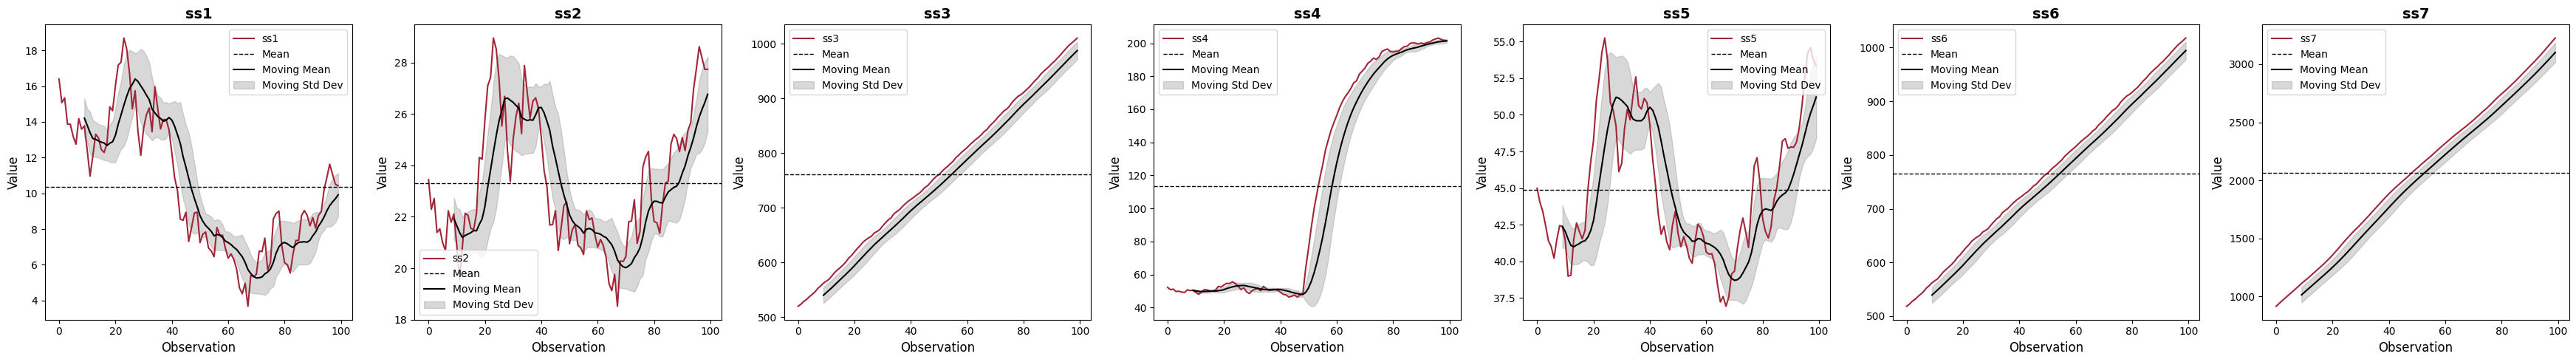

In [7]:
# Define the columns of the original series (assuming they are the first 4)
series_columns = 'ss1', 'ss2', 'ss3', 'ss4', 'ss5', 'ss6', 'ss7'


# Set the window size for the moving average and moving standard deviation
window_size = 10



# Create side-by-side subplots (1 row, one column for each series)
fig, axes = plt.subplots(1, len(series_columns), figsize=(5 * len(series_columns), 5), sharex=True)

# If there is only one series, wrap the axis in a list to maintain the loop
if len(series_columns) == 1:
    axes = [axes]

# Loop to generate the plot for each series
for ax, column in zip(axes, series_columns):
    # Calculate the moving average and moving standard deviation locally
    moving_mean = df[column].rolling(window=window_size).mean()
    moving_std = df[column].rolling(window=window_size).std()
    
    # Calculate the overall mean of the original series
    mean_value = df[column].mean()
    
    # Plot the original series
    ax.plot(df.index, df[column], label=column, color = rgb_color ,linewidth=1.5)
    
    # Draw a horizontal line indicating the mean
    ax.axhline(mean_value, color='black', linestyle='--', linewidth=1, label='Mean')
    
    # Plot the moving average
    ax.plot(df.index, moving_mean, color='black', linewidth=1.5, linestyle='-', label='Moving Mean')
    
    # Plot the moving standard deviation band
    ax.fill_between(df.index, moving_mean - moving_std, moving_mean + moving_std, 
                    color='grey', alpha=0.3, label='Moving Std Dev')
    
    # Remove background and extra borders using the current subplot (ax)
    ax.set_facecolor('white')         # Remove background color
    
    # Set title, labels, and grid
    ax.set_title(column, fontsize=14, fontweight='bold')
    ax.set_xlabel("Observation", fontsize=12)
    ax.set_ylabel("Value", fontsize=12)
    ax.legend()
    ax.grid(False)

plt.tight_layout()
plt.show()


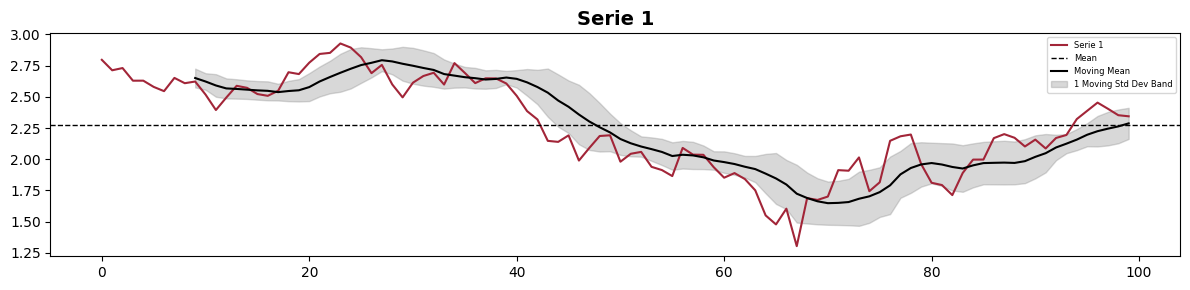

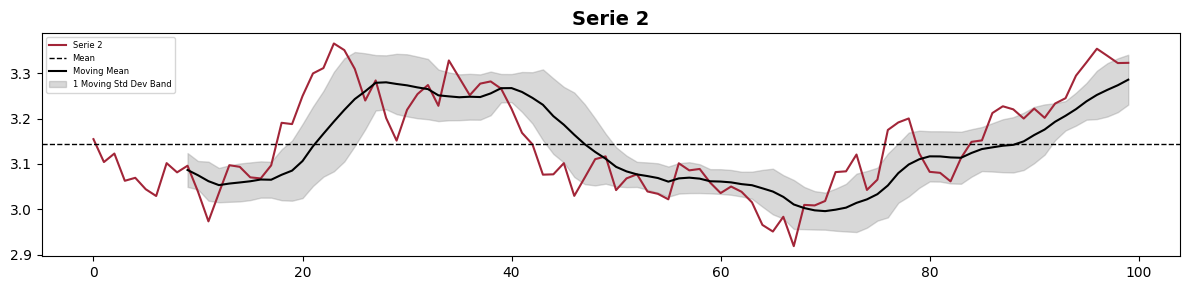

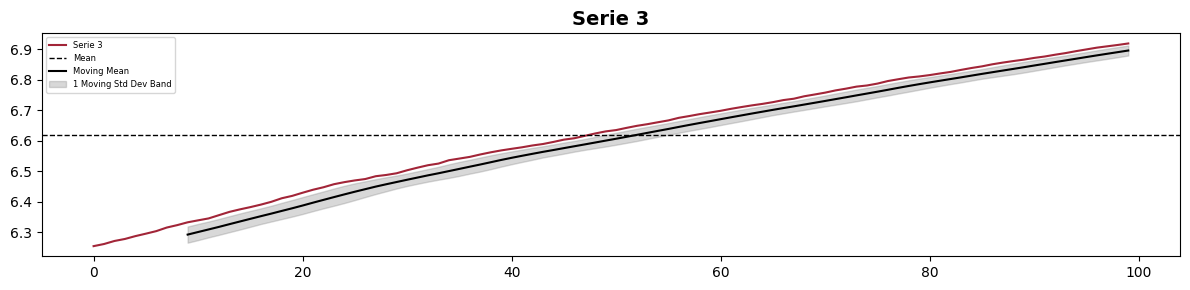

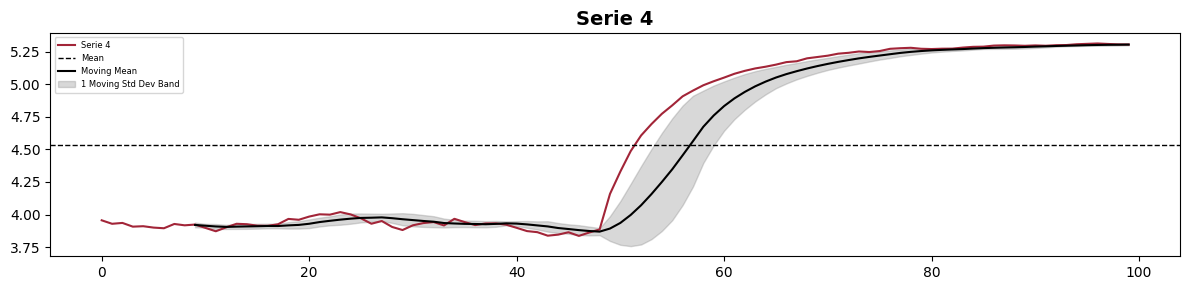

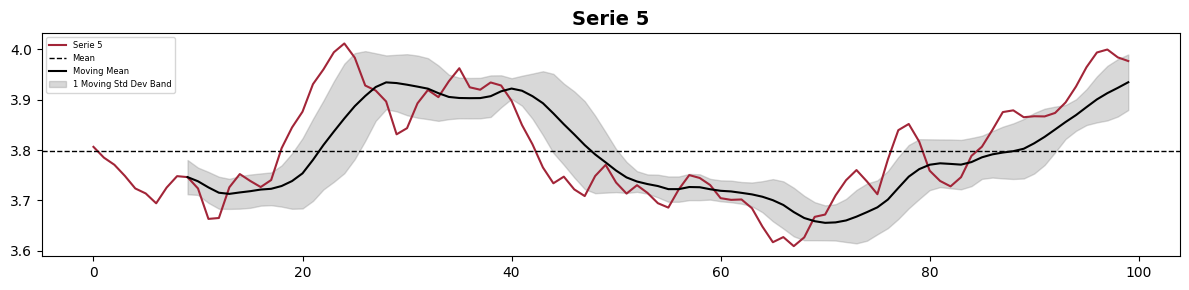

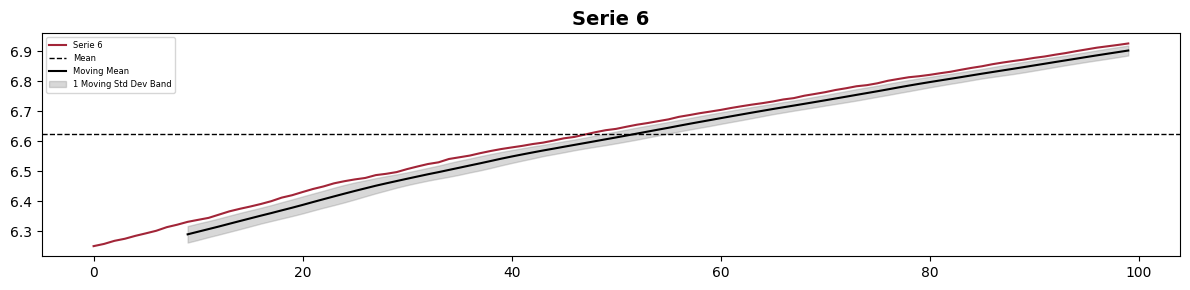

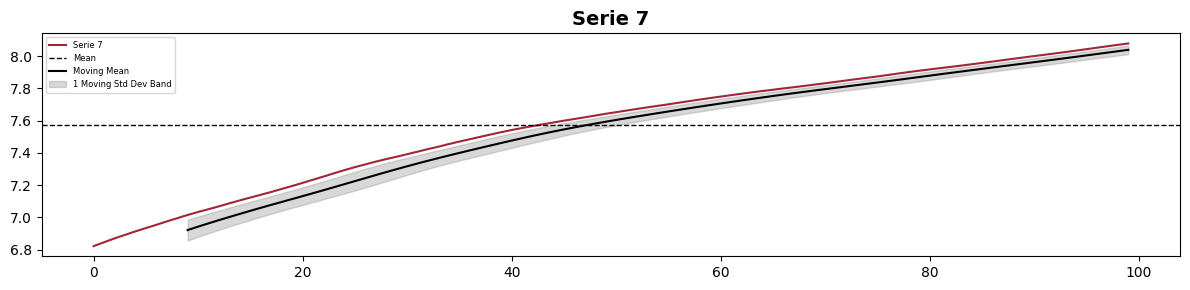

In [24]:
# Define the moving window size
window_size = 10

# Loop through series ss1 to ss7
for i in range(1, 8):
    column = f"ss{i}"
    
    # Calculate moving average and standard deviation
    df['Moving_Mean'] = df[column].rolling(window=window_size).mean()
    df['Moving_Std'] = df[column].rolling(window=window_size).std()
    
    # Calculate mean and std deviation
    mean_value = df[column].mean()
    std_dev = df[column].std()
    
    # Create the plot
    plt.figure(figsize=(12, 3))
    plt.plot(df.index, df[column], color=rgb_color, linewidth=1.5, label=f"Serie {i}")
    plt.axhline(mean_value, color='black', linestyle='--', linewidth=1, label='Mean')

    # Plot moving average
    plt.plot(df.index, df['Moving_Mean'], color='black', linewidth=1.5, linestyle='-', label="Moving Mean")
    
    # Plot moving standard deviation bands
    plt.fill_between(df.index, 
                     df['Moving_Mean'] - df['Moving_Std'], 
                     df['Moving_Mean'] + df['Moving_Std'], 
                     color='grey', alpha=0.3, label='1 Moving Std Dev Band')

    # Add titles and labels
    plt.title(f"Serie {i}", fontsize=14, fontweight='bold')
    plt.xlabel('')
    plt.ylabel('')
    plt.legend(fontsize=6)
    plt.tight_layout()
    plt.show()


#### Stationarity Analysis of Time Series

##### Hard coding
-  The series had to be differenced to achieve stationarity

In [46]:
# Define the series
series_name = 'ss7'
series = df[series_name].dropna()

# Run the Augmented Dickey-Fuller (ADF) test with autolag selection (AIC)
adf_result = adfuller(series, maxlag=None, regression='ct', autolag='AIC', store=False, regresults=False)

# Extract results
stat = adf_result[0]
p_value = adf_result[1]
crit_vals = adf_result[4]

# Build the summary table
adf_summary = pd.DataFrame({
    'Significance Level': ['1%', '5%', '10%'],
    'ADF Statistic': [stat]*3,
    'Critical Value': [crit_vals['1%'], crit_vals['5%'], crit_vals['10%']],
    'Stationarity Result': [
        'Stationary' if stat < crit_vals['1%'] else 'Not Stationary',
        'Stationary' if stat < crit_vals['5%'] else 'Not Stationary',
        'Stationary' if stat < crit_vals['10%'] else 'Not Stationary'
    ]
})

# Display results
print(adf_summary)
print(f"\nNote: The p-value of the test is {p_value:.4f}. The test was estimated with automatic lag selection using AIC and a constant.")


  Significance Level  ADF Statistic  Critical Value Stationarity Result
0                 1%      -1.657476       -4.054251      Not Stationary
1                 5%      -1.657476       -3.456279      Not Stationary
2                10%      -1.657476       -3.153866      Not Stationary

Note: The p-value of the test is 0.7691. The test was estimated with automatic lag selection using AIC and a constant.


In [45]:
# PP
series_name = 'ss7'
series = df[series_name].dropna()

# Run the Phillips-Perron (PP) test with constant only
pp_test = PhillipsPerron(series, trend='ct')

# Extract test statistic, p-value, and critical values
pp_stat = pp_test.stat
p_value = pp_test.pvalue
pp_crit_vals = pp_test.critical_values

# Build the summary table
pp_summary = pd.DataFrame({
    'Significance Level': ['1%', '5%', '10%'],
    'PP Statistic': [pp_stat]*3,
    'Critical Value': [pp_crit_vals['1%'], pp_crit_vals['5%'], pp_crit_vals['10%']],
    'Stationarity Result': [
        'Stationary' if pp_stat < pp_crit_vals['1%'] else 'Not Stationary',
        'Stationary' if pp_stat < pp_crit_vals['5%'] else 'Not Stationary',
        'Stationary' if pp_stat < pp_crit_vals['10%'] else 'Not Stationary'
    ]
})

# Display the result
print(pp_summary)
print(f"\nNote: The p-value of the test is {p_value:.4f}. The test was estimated with a constant and uses Newey-West bandwidth correction.")


  Significance Level  PP Statistic  Critical Value Stationarity Result
0                 1%     -1.736715       -4.054251      Not Stationary
1                 5%     -1.736715       -3.456279      Not Stationary
2                10%     -1.736715       -3.153866      Not Stationary

Note: The p-value of the test is 0.7344. The test was estimated with a constant and uses Newey-West bandwidth correction.


In [48]:
# KPSS
series_name = 'ss7'
series = df[series_name].dropna()

# Run the KPSS test with constant only (trend='c' para n√≠vel, trend='ct' para tend√™ncia)
kpss_stat, p_value, lags, crit_vals = kpss(series, regression='ct', nlags="auto")

# Build the summary table
kpss_summary = pd.DataFrame({
    'Significance Level': ['10%', '5%', '2.5%', '1%'],
    'KPSS Statistic': [round(kpss_stat, 2)]*4,
    'Critical Value': [round(crit_vals['10%'], 2),
                       round(crit_vals['5%'], 2),
                       round(crit_vals['2.5%'], 2),
                       round(crit_vals['1%'], 2)],
    'Stationarity Result': [
        'Not Stationary' if kpss_stat > crit_vals['10%'] else 'Stationary',
        'Not Stationary' if kpss_stat > crit_vals['5%'] else 'Stationary',
        'Not Stationary' if kpss_stat > crit_vals['2.5%'] else 'Stationary',
        'Not Stationary' if kpss_stat > crit_vals['1%'] else 'Stationary'
    ]
})

# Display the result
print(kpss_summary)
print(f"\nNote: The p-value of the test is {p_value:.4f}. The test was estimated with a constant and automatic lag selection.")


  Significance Level  KPSS Statistic  Critical Value Stationarity Result
0                10%             0.2            0.12      Not Stationary
1                 5%             0.2            0.15      Not Stationary
2               2.5%             0.2            0.18      Not Stationary
3                 1%             0.2            0.22          Stationary

Note: The p-value of the test is 0.0154. The test was estimated with a constant and automatic lag selection.


In [39]:
# -------- Zivot-Andrews Test --------
za_test = ZivotAndrews(
    series,
    trend='ct',        # use 'ct' if you expect a trend
    max_lags=12,
    method='aic'
)

print("=== Zivot-Andrews Test ===")
print(f"Test Statistic: {za_test.stat:.4f}")
print(f"P-value: {za_test.pvalue:.4f}")

# Optional: print full summary
# print(za_test.summary())
print("-" * 40)

# Create LaTeX-style summary table for Zivot-Andrews
za_summary = pd.DataFrame({
    'Significance Level': list(za_test.critical_values.keys()),
    'ZA Statistic': [round(za_test.stat, 2)] * len(za_test.critical_values),
    'Critical Value': [round(v, 2) for v in za_test.critical_values.values()],
    'Stationarity Result': [
        'Stationary' if za_test.stat < za_test.critical_values[level] else 'Not Stationary'
        for level in za_test.critical_values
    ]
})

print(za_summary)
print(f"\nNote: The test was estimated with {'trend and intercept' if za_test.trend == 'ct' else 'intercept only'} and automatic lag selection (AIC).")


=== Zivot-Andrews Test ===
Test Statistic: -14.4097
P-value: 0.0008
----------------------------------------
  Significance Level  ZA Statistic  Critical Value Stationarity Result
0                 1%        -14.41           -5.58          Stationary
1                 5%        -14.41           -5.07          Stationary
2                10%        -14.41           -4.83          Stationary

Note: The test was estimated with trend and intercept and automatic lag selection (AIC).


##### Easy coding 1

In [ ]:
# ===============================
# Stationarity Tests for One Series
# ===============================

# Choose your series
series_name = 'ss2'  # change this to ss1, ss3, ..., ss7 as needed
series = df[series_name].dropna()

# -------- ADF Test (Augmented Dickey-Fuller) --------
adf_result = adfuller(series, regression='c', autolag='AIC')  # use 'ct' for trend
print("\n=== ADF Test ===")
print(f"Test Statistic: {adf_result[0]:.4f}")
print(f"P-value: {adf_result[1]:.4f}")
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"  {key}: {value:.4f}")
print("-" * 40)

# -------- DF Test (DFGLS) --------
df_test = DFGLS(series, trend='c')  # use 'ct' for trend
print("=== DF Test ===")
print(f"Test Statistic: {df_test.stat:.4f}")
print(f"P-value: {df_test.pvalue:.4f}")
print("-" * 40)

# -------- Phillips-Perron Test --------
pp_test = PhillipsPerron(series)  # optionally set lags=
print("=== Phillips-Perron Test ===")
print(f"Test Statistic: {pp_test.stat:.4f}")
print(f"P-value: {pp_test.pvalue:.4f}")
print("-" * 40)

# -------- KPSS Test --------
kpss_stat, kpss_p, _, kpss_crit = kpss(series, regression='c', nlags='auto')  # use 'ct' for trend
print("=== KPSS Test ===")
print(f"Test Statistic: {kpss_stat:.4f}")
print(f"P-value: {kpss_p:.4f}")
print("Critical Values:")
for key, value in kpss_crit.items():
    print(f"  {key}: {value:.4f}")
print("-" * 40)

# -------- Zivot-Andrews Test --------
za_test = ZivotAndrews(
    series,
    trend='c',        # use 'ct' if you expect a trend
    max_lags=12,
    method='aic'
)

print("=== Zivot-Andrews Test ===")
print(f"Test Statistic: {za_test.stat:.4f}")
print(f"P-value: {za_test.pvalue:.4f}")

# Check if break_point attribute exists before accessing
if hasattr(za_test, 'break_point'):
    print(f"Break Point (observation index): {za_test.break_point}")
else:
    print("Break Point: not available")

# Optional: print full summary
#print(za_test.summary())
print("-" * 40)




=== ADF Test ===
Test Statistic: -1.6138
P-value: 0.4760
Critical Values:
  1%: -3.4982
  5%: -2.8912
  10%: -2.5826
----------------------------------------
=== DF Test ===
Test Statistic: -1.6633
P-value: 0.0944
----------------------------------------
=== Phillips-Perron Test ===
Test Statistic: -1.7458
P-value: 0.4077
----------------------------------------
=== KPSS Test ===
Test Statistic: 0.1870
P-value: 0.1000
Critical Values:
  10%: 0.3470
  5%: 0.4630
  2.5%: 0.5740
  1%: 0.7390
----------------------------------------
=== Zivot-Andrews Test ===
Test Statistic: -3.7162
P-value: 0.5360
Break Point: not available
----------------------------------------


##### Easy coding 2

In [26]:
def stationarity_tests_verbose(series, name):
    results = {}

    # ADF (Augmented Dickey-Fuller)
    try:
        adf_p = adfuller(series.dropna(), autolag='AIC')[1]
        results['ADF'] = (
            "stationary (unit root rejected)" if adf_p < 0.05
            else "non-stationary (unit root not rejected)"
        )
    except:
        results['ADF'] = "error"

    # DF (Dickey-Fuller classic)
    try:
        df_p = adfuller(series.dropna(), maxlag=0, regression='c')[1]
        results['DF'] = (
            "stationary (unit root rejected)" if df_p < 0.05
            else "non-stationary(unit root not rejected)"
        )
    except:
        results['DF'] = "error"

    # PP
    try:
        pp_p = PhillipsPerron(series.dropna()).pvalue
        results['PP'] = (
            "stationary (unit root rejected)" if pp_p < 0.05
            else "non-stationary (unit root not rejected)"
        )
    except:
        results['PP'] = "error"

    # KPSS
    try:
        kpss_p = kpss(series.dropna(), regression='c', nlags='auto')[1]
        results['KPSS'] = (
            "stationary (null of stationarity not rejected)" if kpss_p > 0.05
            else "non-stationary (null of stationarity rejected)"
        )
    except:
        results['KPSS'] = "error"

    # Zivot-Andrews
    try:
        za_p = ZivotAndrews(series.dropna()).pvalue
        results['Zivot-Andrews'] = (
            "stationary with structural break (unit root rejected)" if za_p < 0.05
            else "non-stationary (unit root not rejected)"
        )
    except:
        results['Zivot-Andrews'] = "error"

    return pd.Series(results, name=name)



In [27]:
series_names = ['ss1', 'ss2', 'ss3', 'ss4', 'ss5', 'ss6', 'ss7']

results_df = pd.DataFrame()

for col in series_names:
    results_df = pd.concat([results_df, stationarity_tests_verbose(df[col], col)], axis=1)

for col in series_names:
    print(f"Results for {col}")
    print(stationarity_tests_verbose(df[col], col))
    print("\n" + "-"*50 + "\n")

Results for ss1
ADF                     non-stationary (unit root not rejected)
DF                       non-stationary(unit root not rejected)
PP                      non-stationary (unit root not rejected)
KPSS             non-stationary (null of stationarity rejected)
Zivot-Andrews           non-stationary (unit root not rejected)
Name: ss1, dtype: object

--------------------------------------------------

Results for ss2
ADF                     non-stationary (unit root not rejected)
DF                       non-stationary(unit root not rejected)
PP                      non-stationary (unit root not rejected)
KPSS             stationary (null of stationarity not rejected)
Zivot-Andrews           non-stationary (unit root not rejected)
Name: ss2, dtype: object

--------------------------------------------------

Results for ss3
ADF                     non-stationary (unit root not rejected)
DF                       non-stationary(unit root not rejected)
PP                      non-

### Question 2

Using the time series obtained from the IPEADATA website, apply unit root tests to the following variables:

- Gross Domestic Product (GDP) at market prices: chained volume index (base year 1995 = 100)
- IPCA - General Price Index (base December 1993 = 100)

Determine whether each series is stationary or not.

Apply the following tests:
- Augmented Dickey-Fuller (ADF)
- Phillips-Perron (PP)
- Kwiatkowski‚ÄìPhillips‚ÄìSchmidt‚ÄìShin (KPSS)
- Zivot-Andrews test for structural breaks
- Any other relevant tests you consider necessary

Include your code in the appendix. Be prepared to explain your results and interpretations if asked.

#### Data

In [49]:
# Here we use a keyword to search for available time series or browse them manually on the IPEA website
ipea.metadata()

# GDP series
ipea.describe('SCN104_PIBPM104')

PIB - pre√ßos de mercado - √≠ndice real encadeado (m√©dia 1995 = 100)
Name            PIB - pre√ßos de mercado - √≠ndice real encadead...                
Code                                              SCN104_PIBPM104                
Big Theme                                          Macroecon√¥mico                
Theme code                                                      8                
Source          Instituto Brasileiro de Geografia e Estat√≠stic...                
Source acronym                                     IBGE/SCN Trim.                
Comment         O produto interno bruto (PIB) √© o total dos be...                
Last update                         2025-03-07T13:32:00.727-03:00                
Frequency                                              Trimestral                
Measure                                                         -                
Unit                                                         None                
Status                                                          A

In [50]:
# IPCA series
ipea.describe('PRECOS12_IPCA12')

IPCA - geral - √≠ndice (dez. 1993 = 100)
Name                      IPCA - geral - √≠ndice (dez. 1993 = 100)
Code                                              PRECOS12_IPCA12
Big Theme                                          Macroecon√¥mico
Theme code                                                      9
Source          Instituto Brasileiro de Geografia e Estat√≠stic...
Source acronym                                         IBGE/SNIPC
Comment         O √çndice Nacional de Pre√ßos ao Consumidor Ampl...
Last update                         2025-04-11T12:10:00.583-03:00
Frequency                                                  Mensal
Measure                                                         -
Unit                                                         None
Status                                                          A

#### Plot the series

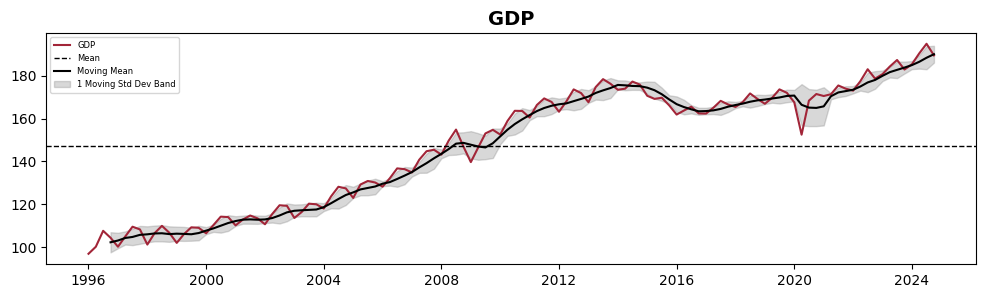

In [51]:
gdp = ipea.timeseries('SCN104_PIBPM104')

gdp = gdp.rename(columns={
    'RAW DATE': 'date',
    'VALUE (-)': 'GDP',
    'CODE': 'code',
    'DAY': 'day',
    'MONTH': 'month',
    'YEAR': 'year'
})
################ Plot ################

column = "GDP"

# Define the moving window size
window_size = 4

# Calculate moving average and moving standard deviation
gdp['Moving_Mean'] = gdp[column].rolling(window=window_size).mean()
gdp['Moving_Std'] = gdp[column].rolling(window=window_size).std()

# Calculate mean and standard deviation
mean_value = gdp[column].mean()
std_dev = gdp[column].std()

# Create the plot
plt.figure(figsize=(12, 3))
plt.plot(gdp.index, gdp[column], color=rgb_color, linewidth=1.5, label="GDP")
plt.axhline(mean_value, color='black', linestyle='--', linewidth=1, label='Mean')  # Dotted line for mean

# Plot standard deviation bands
#plt.fill_between(gdp.index, mean_value - std_dev, mean_value + std_dev, color='gray', alpha=0.3, label='1 Std Dev Band')

# Plot moving average
plt.plot(gdp.index, gdp['Moving_Mean'], color='black', linewidth=1.5, linestyle='-', label="Moving Mean")

# Plot moving standard deviation bands
plt.fill_between(gdp.index, 
                 gdp['Moving_Mean'] - gdp['Moving_Std'], 
                 gdp['Moving_Mean'] + gdp['Moving_Std'], 
                 color='grey', alpha=0.3, label='1 Moving Std Dev Band')

# Add titles and labels
plt.title(column, fontsize=14, fontweight='bold')
plt.xlabel('', fontsize=12)
plt.ylabel('', fontsize=14)
plt.legend(fontsize = 6)
plt.show()


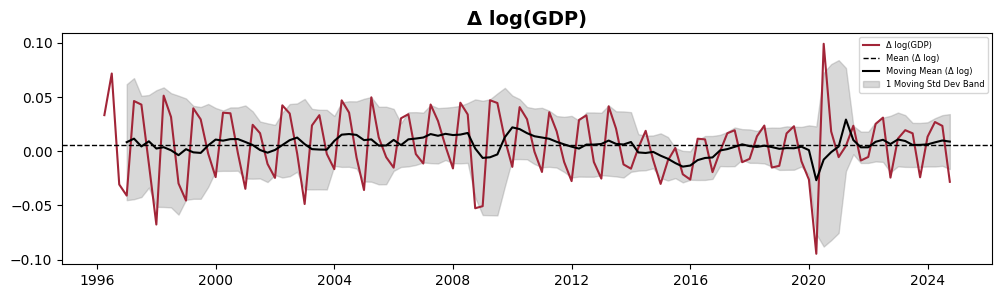

In [52]:
gdp = ipea.timeseries('SCN104_PIBPM104')

gdp = gdp.rename(columns={
    'RAW DATE': 'date',
    'VALUE (-)': 'GDP',
    'CODE': 'code',
    'DAY': 'day',
    'MONTH': 'month',
    'YEAR': 'year'
})

################ Plot Growth Rate ################
# ------ Difference of logs over time represents the growth rate ------

column = "GDP"

# Apply log transformation to the GDP column
gdp['Log_GDP'] = np.log(gdp[column])

# Calculate the first difference of the log
gdp['Log_Diff'] = gdp['Log_GDP'].diff()

# Define the moving window size
window_size = 4

# Calculate moving average and moving standard deviation of the differenced log series
gdp['Moving_Mean'] = gdp['Log_Diff'].rolling(window=window_size).mean()
gdp['Moving_Std'] = gdp['Log_Diff'].rolling(window=window_size).std()

# Calculate overall mean and standard deviation of the differenced log series
mean_value = gdp['Log_Diff'].mean()
std_dev = gdp['Log_Diff'].std()

# Create the plot
plt.figure(figsize=(12, 3))

# Plot the differenced log series
plt.plot(gdp.index, gdp['Log_Diff'], color=rgb_color, linewidth=1.5, label="Œî log(GDP)")

# Horizontal line for the overall mean
plt.axhline(mean_value, color='black', linestyle='--', linewidth=1, label='Mean (Œî log)')

# Plot the moving average
plt.plot(gdp.index, gdp['Moving_Mean'], color='black', linewidth=1.5, linestyle='-', label="Moving Mean (Œî log)")

# Plot the moving standard deviation band
plt.fill_between(gdp.index, 
                 gdp['Moving_Mean'] - gdp['Moving_Std'], 
                 gdp['Moving_Mean'] + gdp['Moving_Std'], 
                 color='grey', alpha=0.3, label='1 Moving Std Dev Band')

# Add title and legend
plt.title('Œî log(' + column + ')', fontsize=14, fontweight='bold')
plt.xlabel('', fontsize=12)
plt.ylabel('', fontsize=14)
plt.legend(fontsize=6)
plt.show()

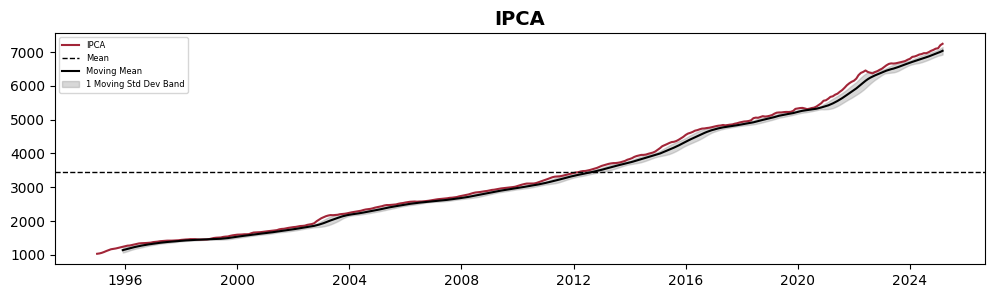

In [53]:
ipca = ipea.timeseries('PRECOS12_IPCA12')

ipca = ipca.rename(columns={
    'RAW DATE': 'date',
    'VALUE (-)': 'IPCA',
    'CODE': 'code',
    'DAY': 'day',
    'MONTH': 'month',
    'YEAR': 'year'
})
################ Plot ################


column = "IPCA"

ipca = ipca[ipca.index >= '1995-01-01']

# Define the moving window size
window_size = 12

# Calculate moving average and moving standard deviation
ipca['Moving_Mean'] = ipca[column].rolling(window=window_size).mean()
ipca['Moving_Std'] = ipca[column].rolling(window=window_size).std()

# Calculate mean and standard deviation
mean_value = ipca[column].mean()
std_dev = ipca[column].std()

# Create the plot
plt.figure(figsize=(12, 3))
plt.plot(ipca.index, ipca[column], color=rgb_color, linewidth=1.5, label="IPCA")
plt.axhline(mean_value, color='black', linestyle='--', linewidth=1, label='Mean')  # Dotted line for mean

# Plot standard deviation bands
#plt.fill_between(ipca.index, mean_value - std_dev, mean_value + std_dev, color='gray', alpha=0.3, label='1 Std Dev Band')

# Plot moving average
plt.plot(ipca.index, ipca['Moving_Mean'], color='black', linewidth=1.5, linestyle='-', label="Moving Mean")

# Plot moving standard deviation bands
plt.fill_between(ipca.index, 
                 ipca['Moving_Mean'] - ipca['Moving_Std'], 
                 ipca['Moving_Mean'] + ipca['Moving_Std'], 
                 color='grey', alpha=0.3, label='1 Moving Std Dev Band')

# Add titles and labels
plt.title(column, fontsize=14, fontweight='bold')
plt.xlabel('', fontsize=12)
plt.ylabel('', fontsize=14)
plt.legend(fontsize = 6)
plt.show()

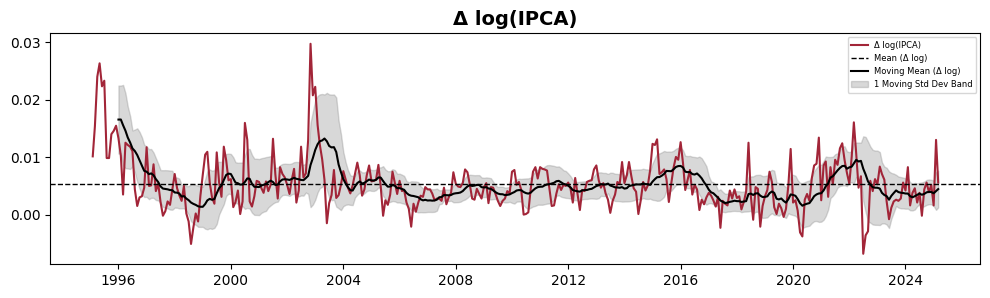

In [54]:
ipca = ipea.timeseries('PRECOS12_IPCA12')

ipca = ipca.rename(columns={
    'RAW DATE': 'date',
    'VALUE (-)': 'IPCA',
    'CODE': 'code',
    'DAY': 'day',
    'MONTH': 'month',
    'YEAR': 'year'
})

################ Plot Growth Rate ################
# ------ Difference of logs over time represents the growth rate ------

column = "IPCA"

# Filter the data from 1995 onwards
ipca = ipca[ipca.index >= '1995-01-01'].copy()

# Apply log transformation to the IPCA column
ipca['Log_IPCA'] = np.log(ipca[column])

# Calculate the first difference of the log
ipca['Log_Diff'] = ipca['Log_IPCA'].diff()

# Define the moving window size
window_size = 12

# Calculate moving average and moving standard deviation of the differenced log series
ipca['Moving_Mean'] = ipca['Log_Diff'].rolling(window=window_size).mean()
ipca['Moving_Std'] = ipca['Log_Diff'].rolling(window=window_size).std()

# Calculate overall mean and standard deviation of the differenced log series
mean_value = ipca['Log_Diff'].mean()
std_dev = ipca['Log_Diff'].std()

# Create the plot
plt.figure(figsize=(12, 3))

# Plot the differenced log series
plt.plot(ipca.index, ipca['Log_Diff'], color=rgb_color, linewidth=1.5, label="Œî log(IPCA)")

# Horizontal line for the overall mean
plt.axhline(mean_value, color='black', linestyle='--', linewidth=1, label='Mean (Œî log)')

# Plot the moving average
plt.plot(ipca.index, ipca['Moving_Mean'], color='black', linewidth=1.5, linestyle='-', label="Moving Mean (Œî log)")

# Plot the moving standard deviation band
plt.fill_between(ipca.index, 
                 ipca['Moving_Mean'] - ipca['Moving_Std'], 
                 ipca['Moving_Mean'] + ipca['Moving_Std'], 
                 color='grey', alpha=0.3, label='1 Moving Std Dev Band')

# Add title and legend
plt.title('Œî log(' + column + ')', fontsize=14, fontweight='bold')
plt.xlabel('', fontsize=12)
plt.ylabel('', fontsize=14)
plt.legend(fontsize=6)
plt.show()

#### Stationarity Analysis of Time Series

##### Hard coding
-  The series had to be differenced to achieve stationarity

In [64]:
gdp['GDP'] = gdp['GDP'].diff()

In [68]:
ipca['IPCA'] = ipca['IPCA'].diff()

In [69]:
# Define the series
series_name = 'IPCA'
series = ipca[series_name].dropna()

# Run the Augmented Dickey-Fuller (ADF) test with autolag selection (AIC)
adf_result = adfuller(series, maxlag=None, regression='ct', autolag='AIC', store=False, regresults=False)

# Extract results
stat = adf_result[0]
p_value = adf_result[1]
crit_vals = adf_result[4]

# Build the summary table
adf_summary = pd.DataFrame({
    'Significance Level': ['1%', '5%', '10%'],
    'ADF Statistic': [stat]*3,
    'Critical Value': [crit_vals['1%'], crit_vals['5%'], crit_vals['10%']],
    'Stationarity Result': [
        'Stationary' if stat < crit_vals['1%'] else 'Not Stationary',
        'Stationary' if stat < crit_vals['5%'] else 'Not Stationary',
        'Stationary' if stat < crit_vals['10%'] else 'Not Stationary'
    ]
})

# Display results
print(adf_summary)
print(f"\nNote: The p-value of the test is {p_value:.4f}. The test was estimated with automatic lag selection using AIC and a constant.")


  Significance Level  ADF Statistic  Critical Value Stationarity Result
0                 1%      -8.012573       -3.984140          Stationary
1                 5%      -8.012573       -3.422756          Stationary
2                10%      -8.012573       -3.134263          Stationary

Note: The p-value of the test is 0.0000. The test was estimated with automatic lag selection using AIC and a constant.


In [70]:
# PP
series_name = 'IPCA'
series = ipca[series_name].dropna()

# Run the Phillips-Perron (PP) test with constant only
pp_test = PhillipsPerron(series, trend='ct')

# Extract test statistic, p-value, and critical values
pp_stat = pp_test.stat
p_value = pp_test.pvalue
pp_crit_vals = pp_test.critical_values

# Build the summary table
pp_summary = pd.DataFrame({
    'Significance Level': ['1%', '5%', '10%'],
    'PP Statistic': [pp_stat]*3,
    'Critical Value': [pp_crit_vals['1%'], pp_crit_vals['5%'], pp_crit_vals['10%']],
    'Stationarity Result': [
        'Stationary' if pp_stat < pp_crit_vals['1%'] else 'Not Stationary',
        'Stationary' if pp_stat < pp_crit_vals['5%'] else 'Not Stationary',
        'Stationary' if pp_stat < pp_crit_vals['10%'] else 'Not Stationary'
    ]
})

# Display the result
print(pp_summary)
print(f"\nNote: The p-value of the test is {p_value:.4f}. The test was estimated with a constant and uses Newey-West bandwidth correction.")


  Significance Level  PP Statistic  Critical Value Stationarity Result
0                 1%    -10.824266       -3.984069          Stationary
1                 5%    -10.824266       -3.422722          Stationary
2                10%    -10.824266       -3.134243          Stationary

Note: The p-value of the test is 0.0000. The test was estimated with a constant and uses Newey-West bandwidth correction.


In [71]:
# KPSS
series_name = 'IPCA'
series = ipca[series_name].dropna()

# Run the KPSS test with constant only (trend='c' para n√≠vel, trend='ct' para tend√™ncia)
kpss_stat, p_value, lags, crit_vals = kpss(series, regression='ct', nlags="auto")

# Build the summary table
kpss_summary = pd.DataFrame({
    'Significance Level': ['10%', '5%', '2.5%', '1%'],
    'KPSS Statistic': [round(kpss_stat, 2)]*4,
    'Critical Value': [round(crit_vals['10%'], 2),
                       round(crit_vals['5%'], 2),
                       round(crit_vals['2.5%'], 2),
                       round(crit_vals['1%'], 2)],
    'Stationarity Result': [
        'Not Stationary' if kpss_stat > crit_vals['10%'] else 'Stationary',
        'Not Stationary' if kpss_stat > crit_vals['5%'] else 'Stationary',
        'Not Stationary' if kpss_stat > crit_vals['2.5%'] else 'Stationary',
        'Not Stationary' if kpss_stat > crit_vals['1%'] else 'Stationary'
    ]
})

# Display the result
print(kpss_summary)
print(f"\nNote: The p-value of the test is {p_value:.4f}. The test was estimated with a constant and automatic lag selection.")


  Significance Level  KPSS Statistic  Critical Value Stationarity Result
0                10%            0.09            0.12          Stationary
1                 5%            0.09            0.15          Stationary
2               2.5%            0.09            0.18          Stationary
3                 1%            0.09            0.22          Stationary

Note: The p-value of the test is 0.1000. The test was estimated with a constant and automatic lag selection.


In [ ]:
# -------- Zivot-Andrews Test --------
za_test = ZivotAndrews(
    series,
    trend='ct',        # use 'ct' if you expect a trend
    max_lags=12,
    method='aic'
)

print("=== Zivot-Andrews Test ===")
print(f"Test Statistic: {za_test.stat:.4f}")
print(f"P-value: {za_test.pvalue:.4f}")

# Optional: print full summary
# print(za_test.summary())
print("-" * 40)

# Create LaTeX-style summary table for Zivot-Andrews
za_summary = pd.DataFrame({
    'Significance Level': list(za_test.critical_values.keys()),
    'ZA Statistic': [round(za_test.stat, 2)] * len(za_test.critical_values),
    'Critical Value': [round(v, 2) for v in za_test.critical_values.values()],
    'Stationarity Result': [
        'Stationary' if za_test.stat < za_test.critical_values[level] else 'Not Stationary'
        for level in za_test.critical_values
    ]
})

print(za_summary)
print(f"\nNote: The test was estimated with {'trend and intercept' if za_test.trend == 'ct' else 'intercept only'} and automatic lag selection (AIC).")


=== Zivot-Andrews Test ===
Test Statistic: -14.4097
P-value: 0.0008
----------------------------------------
  Significance Level  ZA Statistic  Critical Value Stationarity Result
0                 1%        -14.41           -5.58          Stationary
1                 5%        -14.41           -5.07          Stationary
2                10%        -14.41           -4.83          Stationary

Note: The test was estimated with trend and intercept and automatic lag selection (AIC).


##### Easy coding 1 

In [39]:
def stationarity_tests_verbose(series, name):
    results = {}

    # ADF (Augmented Dickey-Fuller)
    try:
        adf_p = adfuller(series.dropna(), autolag='AIC')[1]
        results['ADF'] = (
            "stationary (unit root rejected)" if adf_p < 0.05
            else "non-stationary (unit root not rejected)"
        )
    except:
        results['ADF'] = "error"

    # DF (Dickey-Fuller classic)
    try:
        df_p = adfuller(series.dropna(), maxlag=0, regression='c')[1]
        results['DF'] = (
            "stationary (unit root rejected)" if df_p < 0.05
            else "non-stationary (unit root not rejected)"
        )
    except:
        results['DF'] = "error"

    # PP
    try:
        pp_p = PhillipsPerron(series.dropna()).pvalue
        results['PP'] = (
            "stationary (unit root rejected)" if pp_p < 0.05
            else "non-stationary (unit root not rejected)"
        )
    except:
        results['PP'] = "error"

    # KPSS
    try:
        kpss_p = kpss(series.dropna(), regression='c', nlags='auto')[1]
        results['KPSS'] = (
            "stationary (null of stationarity not rejected)" if kpss_p > 0.05
            else "non-stationary (null of stationarity rejected)"
        )
    except:
        results['KPSS'] = "error"

    # Zivot-Andrews
    try:
        za_p = ZivotAndrews(series.dropna()).pvalue
        results['Zivot-Andrews'] = (
            "stationary with structural break (unit root rejected)" if za_p < 0.05
            else "non-stationary (unit root not rejected)"
        )
    except:
        results['Zivot-Andrews'] = "error"

    return pd.Series(results, name=name)



In [42]:
# Run tests on GDP and Log_GDP
gdp_result = stationarity_tests_verbose(gdp['GDP'], name='GDP')
log_gdp_result = stationarity_tests_verbose(gdp['Log_GDP'], name='Log_GDP')

# Run tests on IPCA and Log_IPCA
ipca_result = stationarity_tests_verbose(ipca['IPCA'], name='IPCA')
log_ipca_result = stationarity_tests_verbose(ipca['Log_IPCA'], name='Log_IPCA')

# Exibir como texto, limpo para PDF
for name, result in [('GDP', gdp_result), 
                     ('Log_GDP', log_gdp_result), 
                     ('IPCA', ipca_result), 
                     ('Log_IPCA', log_ipca_result)]:
    print(f"Stationarity Test Results for {name}")
    print(result)
    print("\n" + "-"*60 + "\n")

Stationarity Test Results for GDP
ADF                     non-stationary (unit root not rejected)
DF                      non-stationary (unit root not rejected)
PP                      non-stationary (unit root not rejected)
KPSS             non-stationary (null of stationarity rejected)
Zivot-Andrews           non-stationary (unit root not rejected)
Name: GDP, dtype: object

------------------------------------------------------------

Stationarity Test Results for Log_GDP
ADF                     non-stationary (unit root not rejected)
DF                      non-stationary (unit root not rejected)
PP                      non-stationary (unit root not rejected)
KPSS             non-stationary (null of stationarity rejected)
Zivot-Andrews           non-stationary (unit root not rejected)
Name: Log_GDP, dtype: object

------------------------------------------------------------

Stationarity Test Results for IPCA
ADF                     non-stationary (unit root not rejected)
DF       